In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport compute_comethylation, utils, analysis
%autoreload 1
import get_data, analysis, utils, plotting, compute_comethylation, methyl_mut_burden, somatic_mut_clock, mutation_features, methylation_pred

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr
from rich.progress import track
import statsmodels.formula.api as smf
import matplotlib.ticker as ticker
from scipy.stats import spearmanr, pearsonr
from scipy import stats
import dask
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from pyfaidx import Fasta


%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

/tmp/ipykernel_2450085/2781717483.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-deep")


# TCGA data

In [21]:
# qnorm data
all_mut_w_age_df, illumina_cpg_locs_df, all_methyl_age_df_t, matrix_qtl_dir, covariate_fn = get_data.read_tcga_data()

reading in data
Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


# ICGC data

In [3]:
# qnorm 
icgc_mut_w_age_df, illumina_cpg_locs_df, icgc_methyl_age_df_t, icgc_matrix_qtl_dir, icgc_covariate_fn = get_data.read_icgc_data()

reading in data
Got mutations and metadata, reading methylation
Got methylation, transposing
Done


,case_submitter_id,chr,start,end,reference,alt,DNA_VAF,mutation,dataset,gender,dataset_r,gender_r,age_at_index
0,DO35009,16,10093626,10093626,C,A,0.136364,C>A,PACA,MALE,PACA,MALE,64
1,DO35009,10,6726330,6726330,G,C,0.275229,G>C,PACA,MALE,PACA,MALE,64
2,DO35009,10,107021254,107021254,C,A,0.432203,C>A,PACA,MALE,PACA,MALE,64
3,DO35009,1,26892465,26892465,A,G,0.176471,A>G,PACA,MALE,PACA,MALE,64
4,DO35009,8,96203326,96203326,A,T,0.275862,A>T,PACA,MALE,PACA,MALE,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919284,DO229096,20,23691266,23691266,G,C,0.469388,G>C,UTCA,FEMALE,UTCA,FEMALE,65
3919285,DO229096,12,128689264,128689264,A,T,0.285714,A>T,UTCA,FEMALE,UTCA,FEMALE,65
3919286,DO229096,12,128689264,128689264,A,T,0.329114,A>T,UTCA,FEMALE,UTCA,FEMALE,65
3919287,DO229096,X,122587198,122587198,C,T,0.250000,C>T,UTCA,FEMALE,UTCA,FEMALE,65


In [7]:
from pyfaidx import Fasta
reference_genome = Fasta(
    '/cellar/users/zkoch/methylation_and_mutation/data/genome_annotations/hg19.fa'
    )
cpg_islands = pd.read_csv(
    '/cellar/users/zkoch/methylation_and_mutation/data/genome_annotations/CpG_islands_hg19.bed.gz',
    sep = '\t', header = None
    )

In [12]:
icgc_mut_w_age_df = icgc_mut_w_age_df.query("chr != 'MT'")

In [13]:
icgc_mut_w_age_df['seq'] = icgc_mut_w_age_df.apply(
    lambda x: reference_genome['chr'+x['chr']][x['start']-2: x['start'] + 1].seq,
    axis = 1)

/tmp/ipykernel_2450085/2378999128.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icgc_mut_w_age_df['seq'] = icgc_mut_w_age_df.apply(


In [18]:
icgc_mut_w_age_df['is_cpg'] = icgc_mut_w_age_df['seq'].str.upper().str.contains('CG')

/tmp/ipykernel_2450085/1800473349.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icgc_mut_w_age_df['is_cpg'] = icgc_mut_w_age_df['seq'].str.upper().str.contains('CG')


In [15]:
icgc_mut_w_age_df['new_seq'] = icgc_mut_w_age_df.apply(
            lambda row: row['seq'][0] + row['alt'] + row['seq'][2],
            axis = 1)

/tmp/ipykernel_2450085/1064797903.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icgc_mut_w_age_df['new_seq'] = icgc_mut_w_age_df.apply(


# ICGC

## Fig 1A, 1B, S1

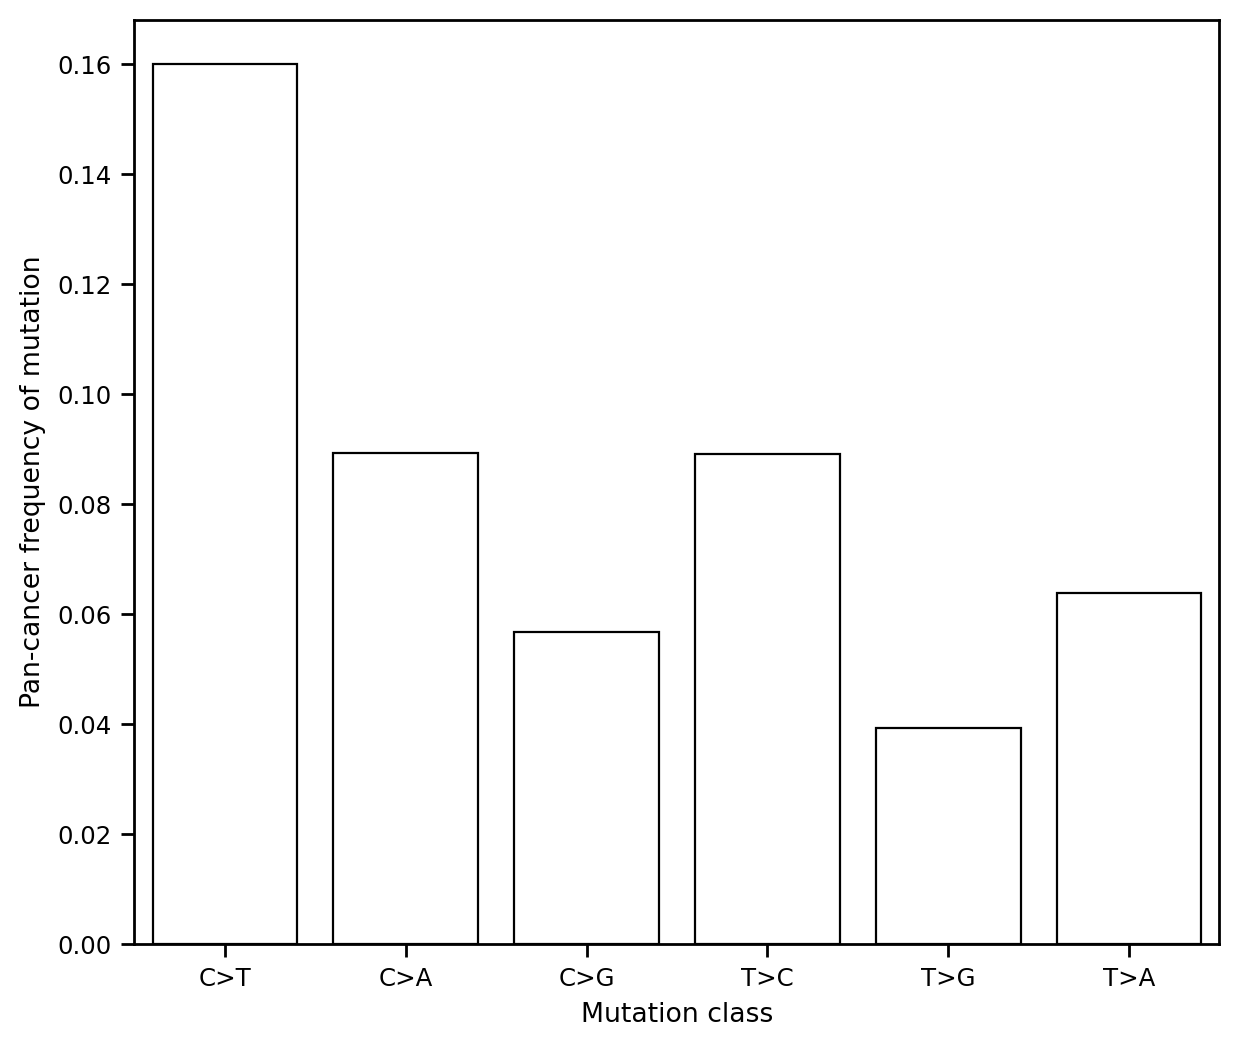

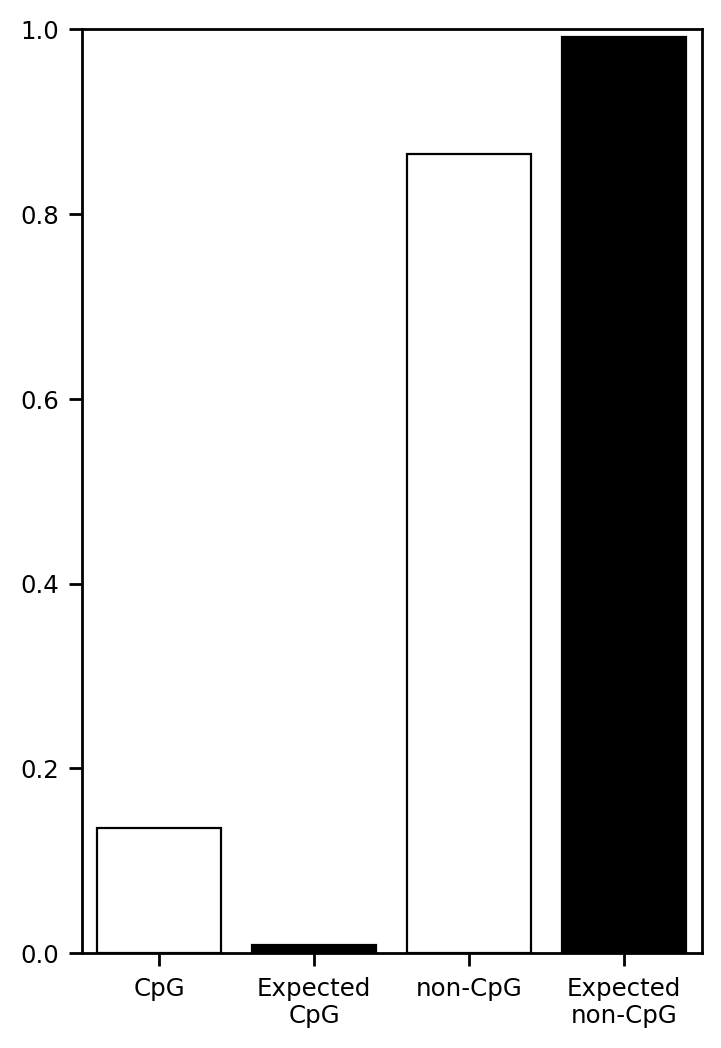

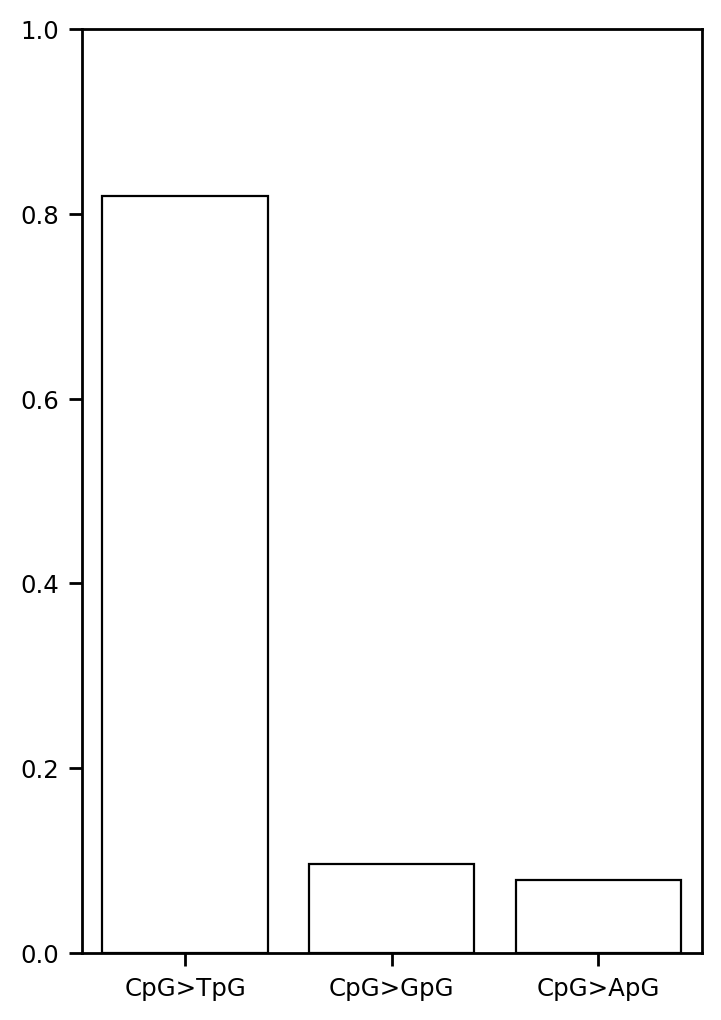

In [20]:
analysis.plot_mutations_distributions(icgc_mut_w_age_df, illumina_cpg_locs_df, icgc_methyl_age_df_t)

## Fig 1C

In [23]:
mut_in_measured_cpg_df = utils.join_df_with_illum_cpg(icgc_mut_w_age_df, illumina_cpg_locs_df, icgc_methyl_age_df_t)
mutated_atleast_once = mut_in_measured_cpg_df['#id'].to_list()
never_mutated = list(
    set(icgc_methyl_age_df_t.iloc[:,3:].columns) 
    - set(mutated_atleast_once)
    )

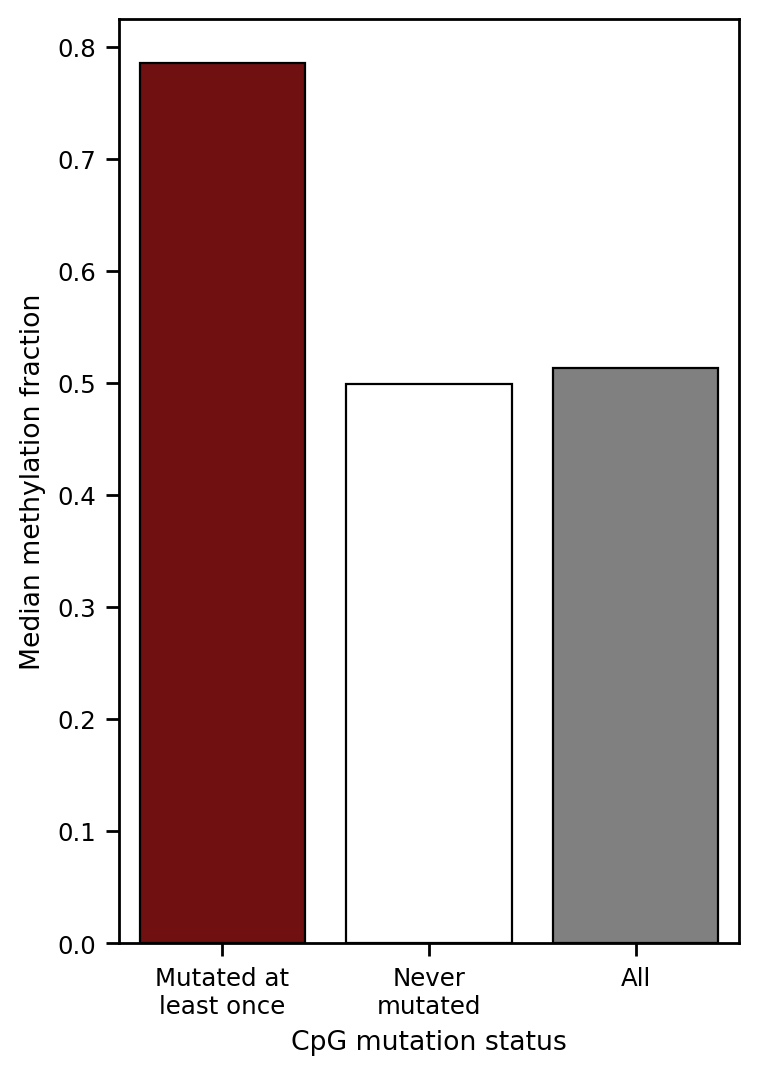

In [27]:
"""to_plot = pd.DataFrame(
    {'Mutated at\nleast once': all_methyl_age_df_t.loc[:,mutated_atleast_once].mean(axis = 0).median(),
     'Never\nmutated': all_methyl_age_df_t.loc[:,never_mutated].mean(axis = 0).median(),
    'All': all_methyl_age_df_t.mean(axis = 0).median()}, index = ['Median methylation fraction']
    )"""

fig, axes = plt.subplots(figsize=(4,6), dpi = 100)
sns.set_context('paper')
sns.barplot(data = to_plot.T.reset_index().rename(columns = {'index': 'CpG mutation status'}), x = 'CpG mutation status', y = 'Median methylation fraction', palette =['maroon', 'white', 'grey'], edgecolor = 'black', ax = axes)

plt.savefig("/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/figure1/figure1C_ICGC_median_methyl_by_mutated.svg",format='svg', dpi = 300)

# TCGA

## Fig 1A, Fig 1B, Supplemental figure 1, 

In [4]:
dependency_f_dir = '/cellar/users/zkoch/methylation_and_mutation/dependency_files'
all_mut_df = pd.read_parquet(os.path.join(dependency_f_dir, 'all_mut_df_w_seq.parquet'))

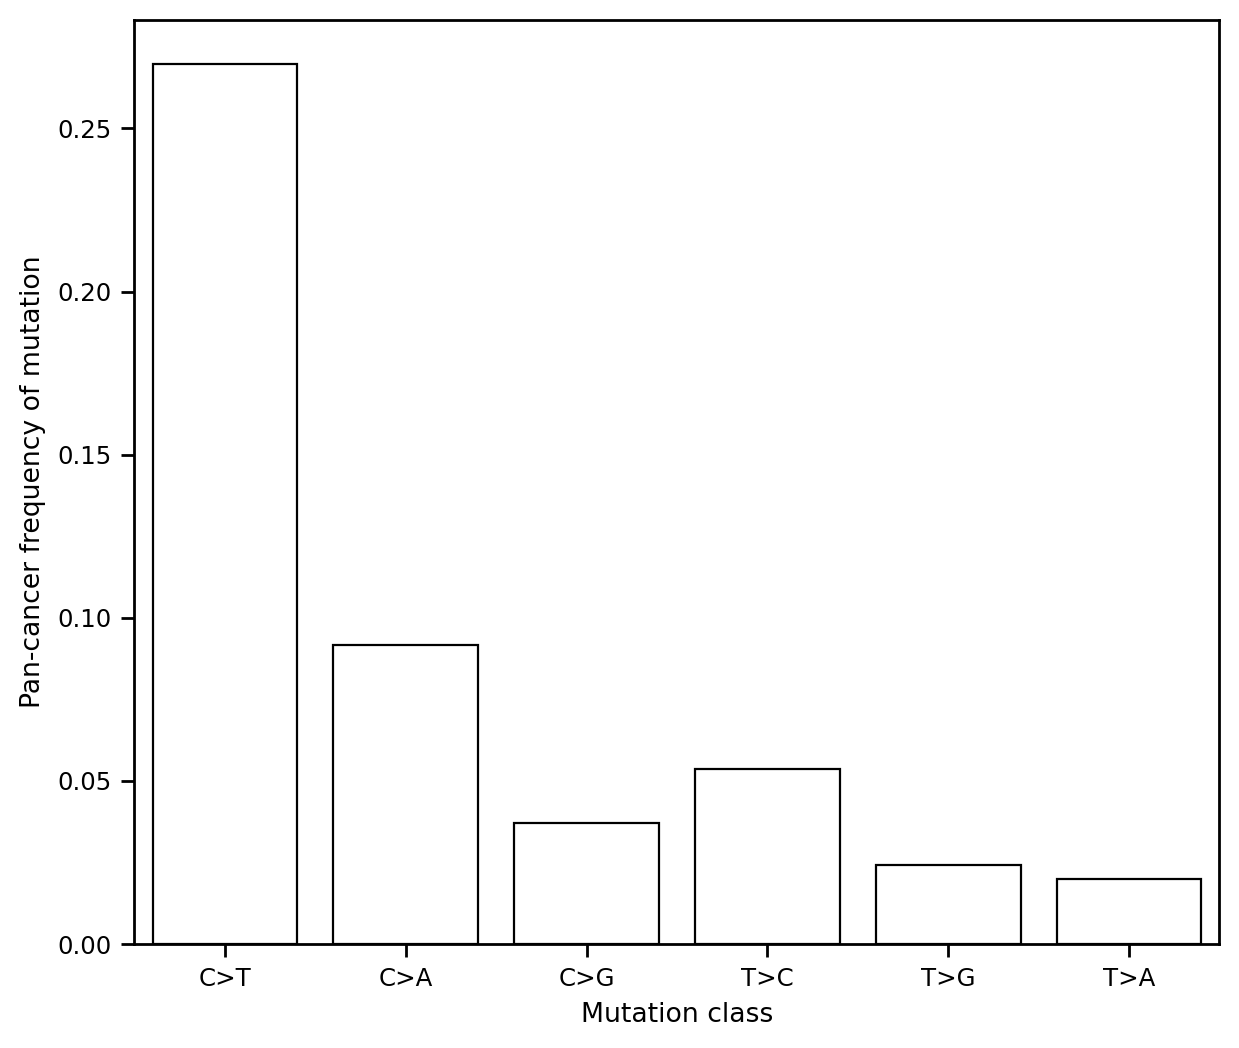

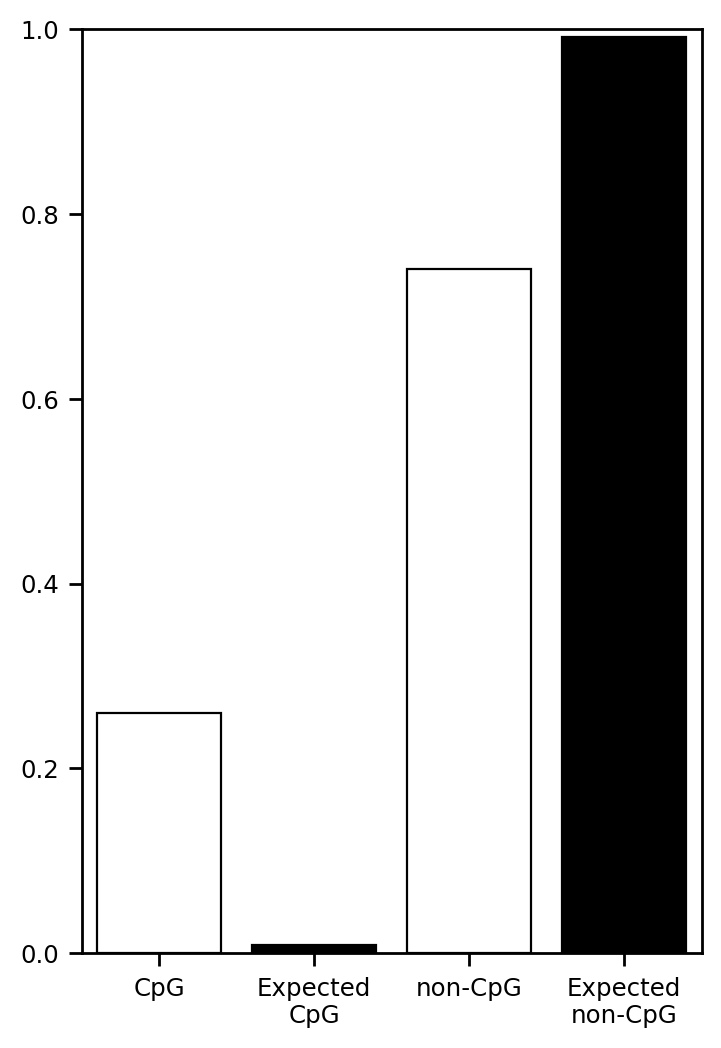

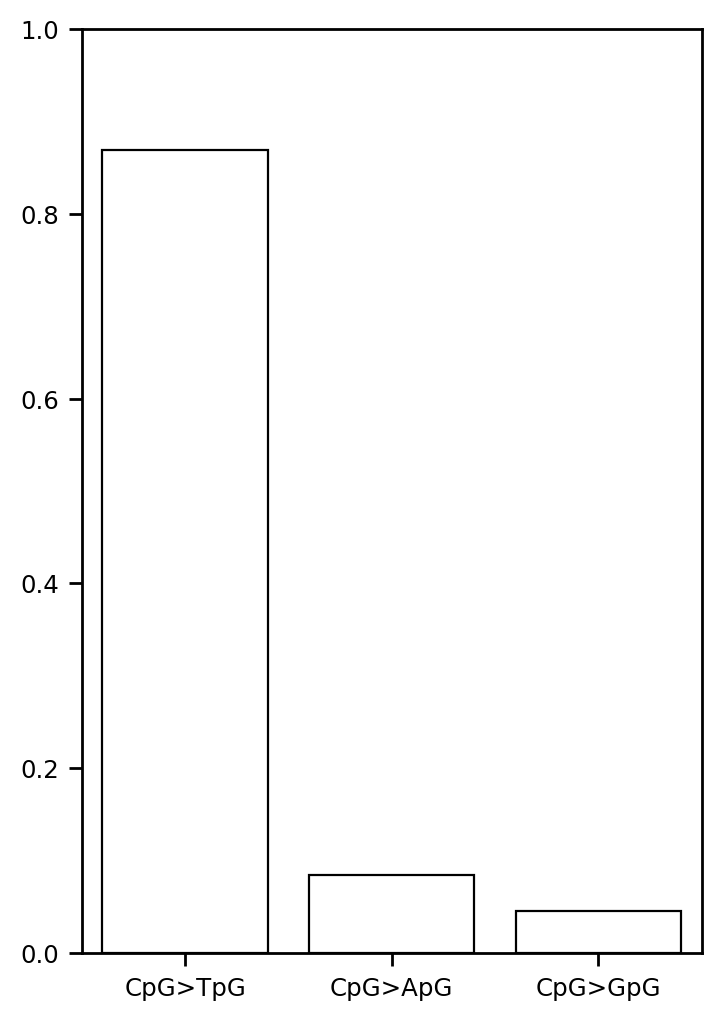

In [22]:
analysis.plot_mutations_distributions(all_mut_df, illumina_cpg_locs_df, all_methyl_age_df_t)

## 1C: mean methyl by mutated

In [24]:
mut_in_measured_cpg_df = utils.join_df_with_illum_cpg(all_mut_df, illumina_cpg_locs_df, all_methyl_age_df_t)
mutated_atleast_once = mut_in_measured_cpg_df['#id'].to_list()
never_mutated = list(set(all_methyl_age_df_t.iloc[:,3:].columns) - set(mutated_atleast_once))

/tmp/ipykernel_2450085/3103324962.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  'All': all_methyl_age_df_t.mean(axis = 0).median()}, index = ['Median methylation fraction']


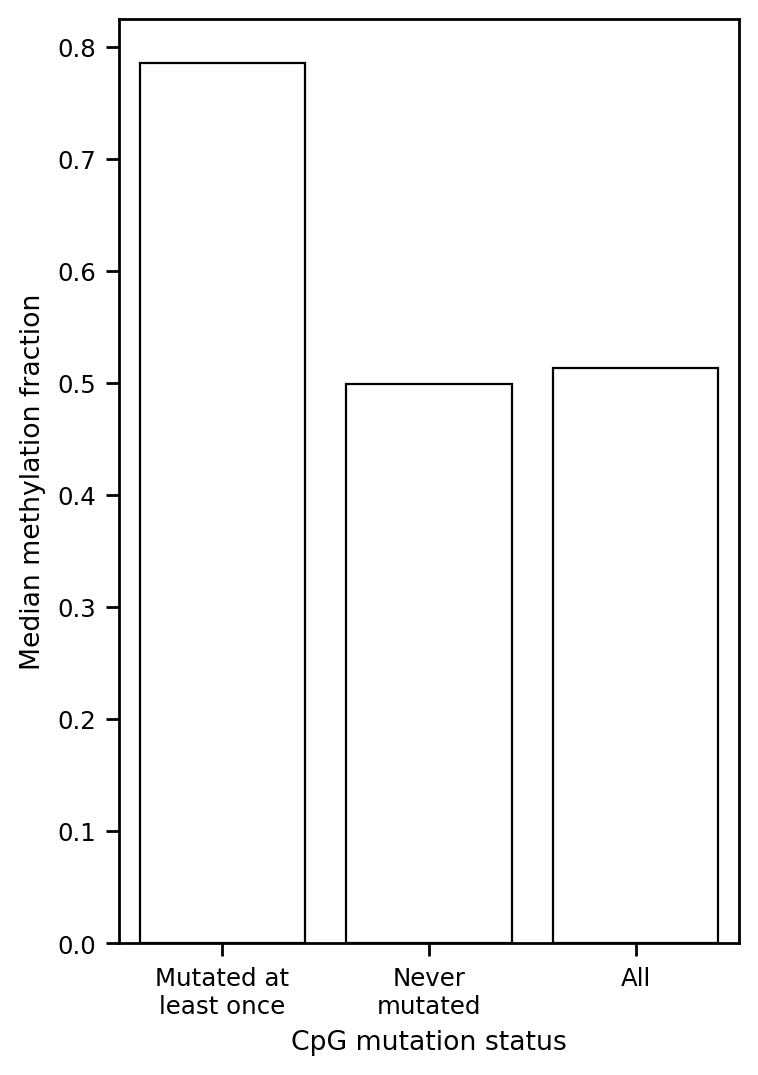

In [25]:
to_plot = pd.DataFrame(
    {'Mutated at\nleast once': all_methyl_age_df_t.loc[:,mutated_atleast_once].mean(axis = 0).median(),
     'Never\nmutated': all_methyl_age_df_t.loc[:,never_mutated].mean(axis = 0).median(),
    'All': all_methyl_age_df_t.mean(axis = 0).median()}, index = ['Median methylation fraction']
    )

fig, axes = plt.subplots(figsize=(4,6), dpi = 100)
sns.set_context('paper')
sns.barplot(data = to_plot.T.reset_index().rename(columns = {'index': 'CpG mutation status'}), x = 'CpG mutation status', y = 'Median methylation fraction', color = 'white', edgecolor = 'black', ax = axes)

plt.savefig("/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/figure1/figure1C_TCGA_median_methyl_by_mutated.svg",format='svg', dpi = 300)

## 1E: KDE

In [10]:
mut_in_measured_cpg_df = utils.join_df_with_illum_cpg(all_mut_df, illumina_cpg_locs_df, all_methyl_age_df_t)
mutated_atleast_once = mut_in_measured_cpg_df['#id'].to_list()
never_mutated = list(set(all_methyl_age_df_t.iloc[:,3:].columns) - set(mutated_atleast_once))

In [11]:
mut_in_measured_cpg_df['methyl_fraction'] = utils.get_methyl_fractions(mut_in_measured_cpg_df, all_methyl_age_df_t)
mut_in_measured_cpg_df['avg_methyl_frac'] = all_methyl_age_df_t[mut_in_measured_cpg_df['#id']].mean().values
mut_in_measured_cpg_df['difference'] = mut_in_measured_cpg_df['methyl_fraction'] - mut_in_measured_cpg_df['avg_methyl_frac']

/cellar/users/zkoch/methylation_and_mutation/source_files/analysis.py:115: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  non_mutated_methyl_df_t.mean(axis=0)
/cellar/users/zkoch/methylation_and_mutation/source_files/analysis.py:119: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  to_plot_df['Type'] = ['Non mutated CpGs'] * len(mutation_in_measured_cpg_df['avg_methyl_frac']) +  ['Mutated CpGs'] * len(mutation_in_measured_cpg_df['methyl_fraction']) + ['Site of no CpG mutation'] * len(non_mutated_methyl_df_t.mean(axis=0))


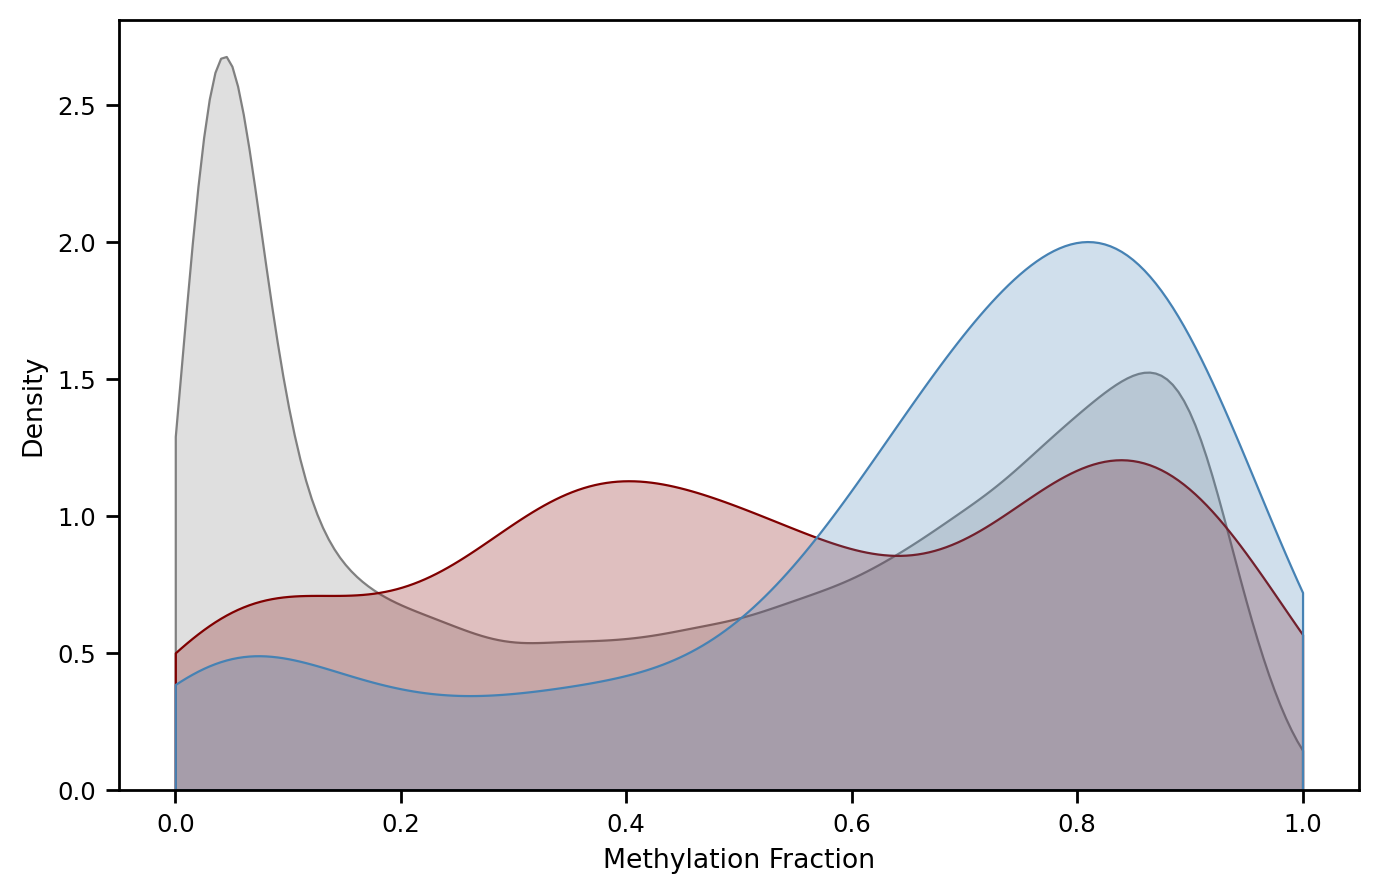

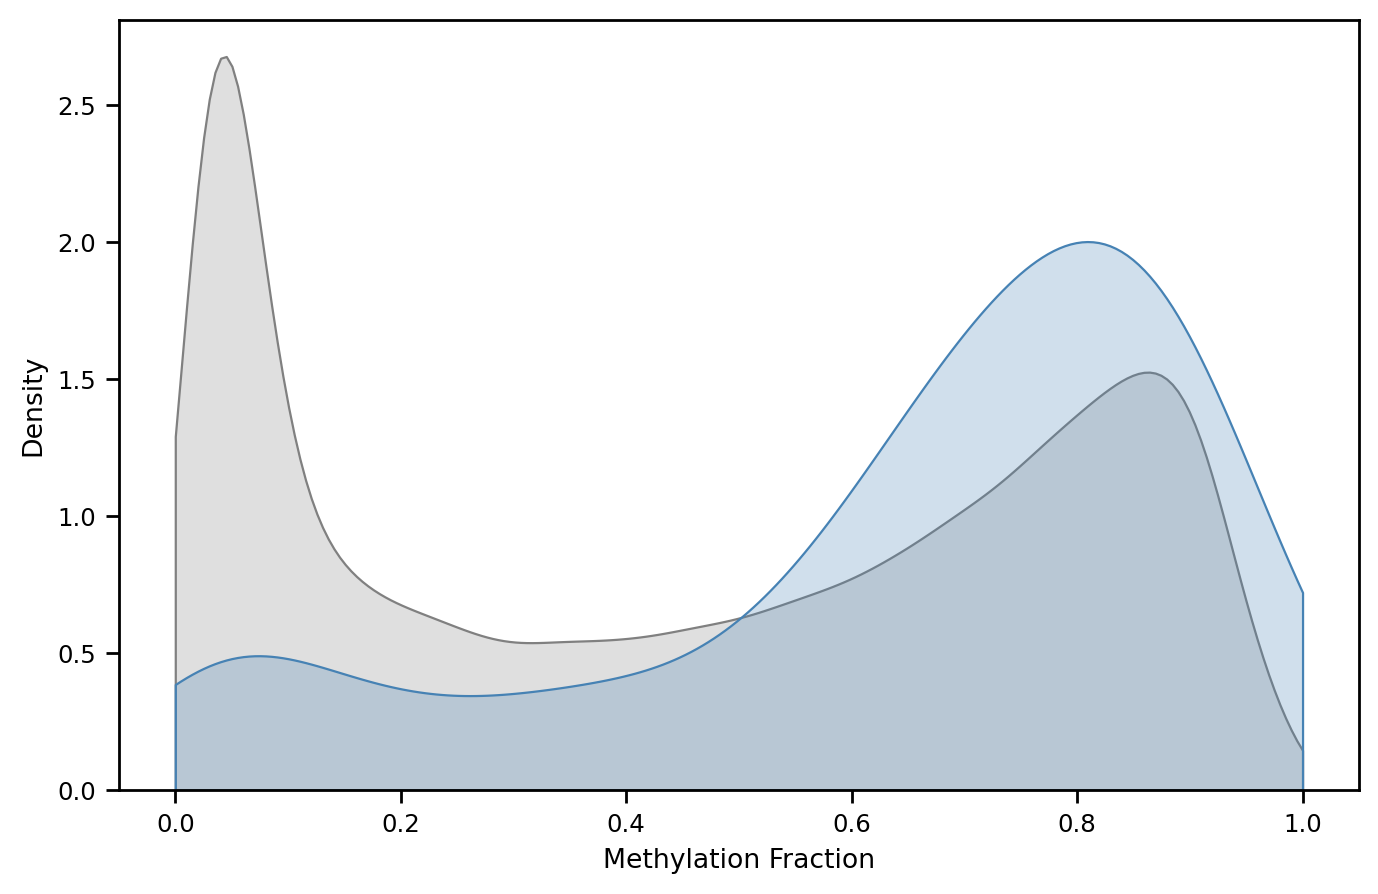

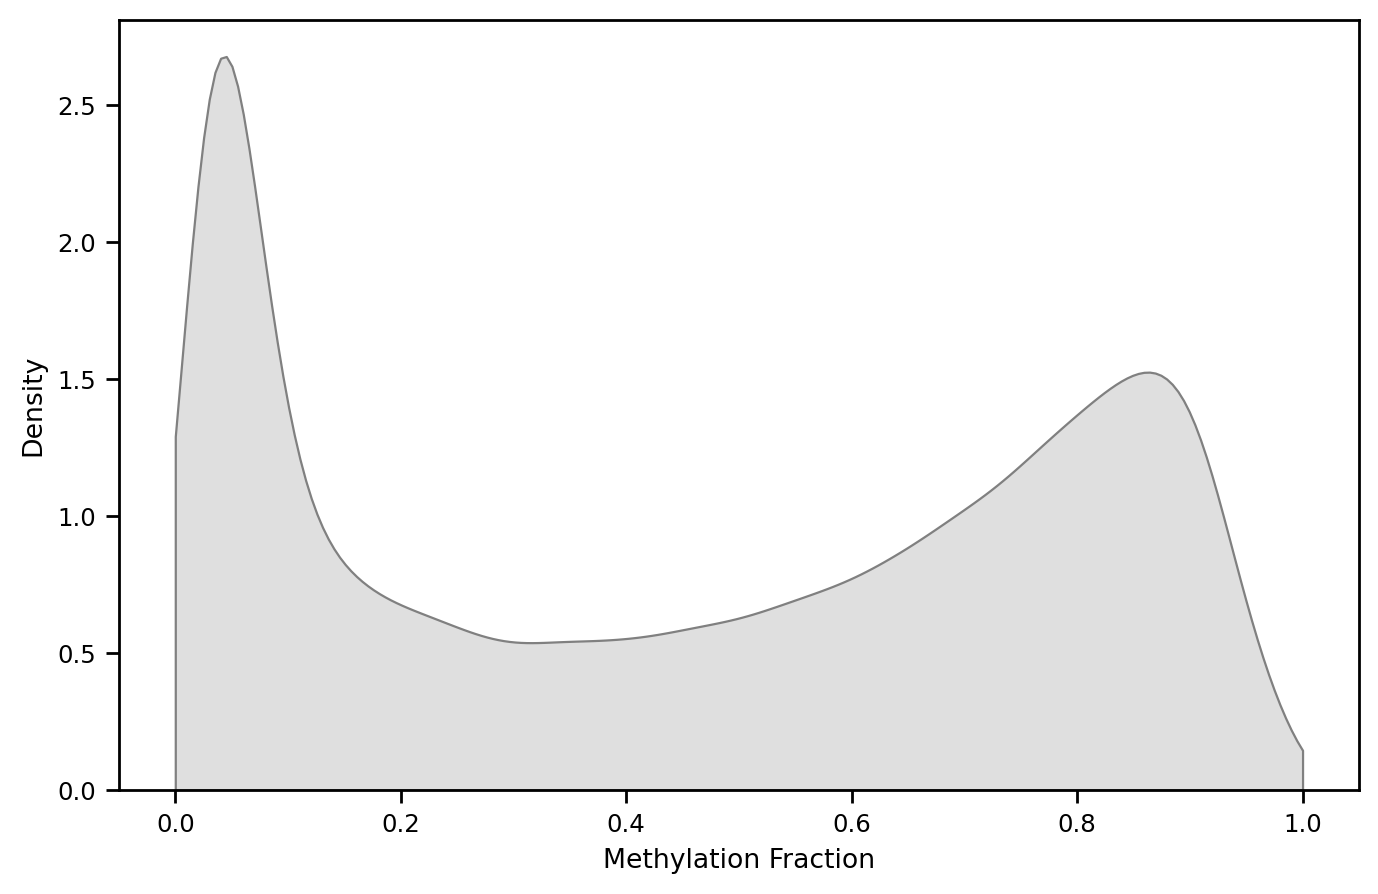

In [12]:
_ = analysis.compare_mf_mutated_sample_vs_avg(mut_in_measured_cpg_df, all_methyl_age_df_t)

In [29]:
stats.mannwhitneyu(
    to_plot_df.query('Type == "Non mutated CpGs"')['Methylation Fraction'], 
    to_plot_df.query('Type == "Site of no CpG mutation"')['Methylation Fraction']
    )

MannwhitneyuResult(statistic=51292291.0, pvalue=2.7323219459884468e-24)

In [31]:
stats.mannwhitneyu(
    to_plot_df.query('Type == "Non mutated CpGs"')['Methylation Fraction'], 
    to_plot_df.query('Type == "Mutated CpGs"')['Methylation Fraction']
    )

MannwhitneyuResult(statistic=52538.0, pvalue=3.87264825594618e-09)

In [32]:
stats.mannwhitneyu(
    to_plot_df.query('Type == "Site of no CpG mutation"')['Methylation Fraction'], 
    to_plot_df.query('Type == "Mutated CpGs"')['Methylation Fraction']
    )

MannwhitneyuResult(statistic=33913986.0, pvalue=0.0013963142273233774)

In [14]:
mut_in_measured_cpg_w_methyl_age_df.groupby('mutation')['difference'].describe()

,count,mean,std,min,25%,50%,75%,max
mutation,,,,,,,,
C>T,6984.0,-0.070359,0.158571,-0.765627,-0.167918,-0.02812,0.020951,0.700863


## 1F

In [13]:
# bin mut_in_measured_cpg_w_methyl_age_df['DNA_VAF'] into 5 equal width bins from 0 to 1
mut_in_measured_cpg_df['VAF_bin'] = pd.cut(
                mut_in_measured_cpg_df['DNA_VAF'],
                bins = 5,
                labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1']
                )

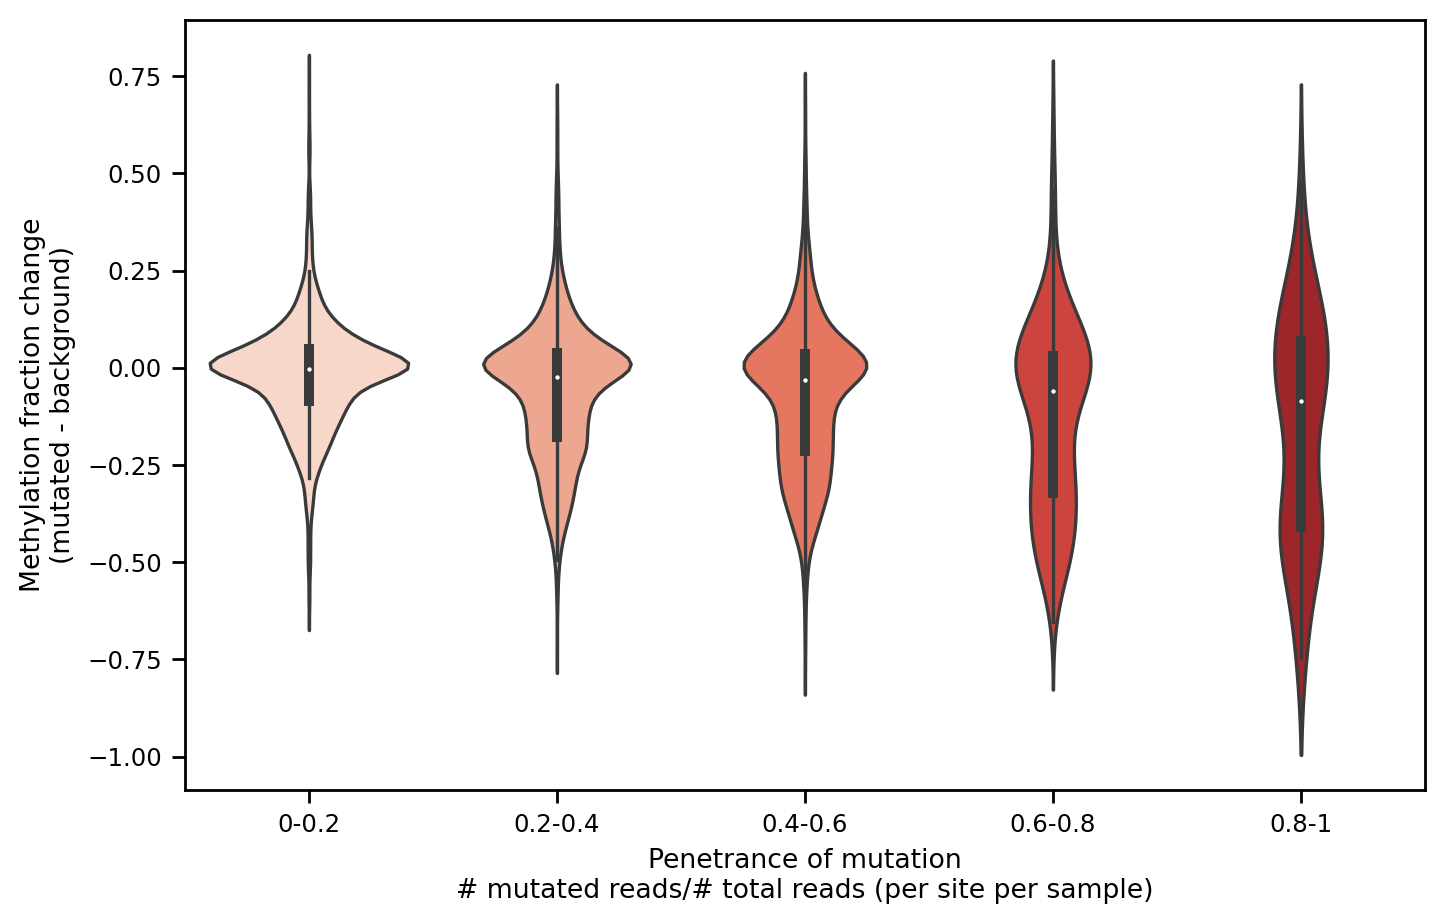

In [14]:
# new way
sns.set_context('paper')
# make bigger figure
plt.figure(figsize=(8,5), dpi=100)
sns.violinplot(data = mut_in_measured_cpg_df, x = 'VAF_bin', y = 'difference', showfliers=False, palette = 'Reds')
plt.ylabel('Methylation fraction change\n(mutated - background)')
plt.xlabel('Penetrance of mutation\n# mutated reads/# total reads (per site per sample)')
plt.savefig("/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/figure1/figure1F_penetrance_vs_DMF.svg",format='svg', dpi = 300)
